# Research question 7

### How do movie endings vary by film length ? This question would explore whether movies of different lengths (e.g., short vs. feature-length) tend to have different types of endings.

This notebook presents initial observations and is not intended to represent the final conclusions.

##### Importations

In [90]:
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import kstest
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [91]:
# path
DATA_FOLDER = '../../src/data/'
MOVIE_DATASET = DATA_FOLDER + 'movies_dataset_final.tsv'

# Dataset loading
movies = pd.read_csv(MOVIE_DATASET, sep='\t')

### Test for two categories

These statistical analyses were conducted to compare movie scores based on film length, differentiated by a specified threshold. The tests used (such as normality tests, Levene's test for equality of variances, T-tests, and Mann-Whitney U tests) ensure that the assumptions of the selected statistical methods are met. Normality tests verify if the score distributions follow a normal distribution, while Levene's test checks for homogeneity of variances between the two categories (short and feature-length). Depending on these results, either a T-test (assuming equal variances) or Welch's T-test (if variances are unequal) can be used, or the non-parametric Mann-Whitney U test is applied if necessary. This systematic approach guarantees accurate statistical comparison while considering the underlying data characteristics.

In [98]:
def analyze_movie_endings_by_threshold(movies, threshold=40, verbose=True):
   
    # Check the required columns
    if 'Movie runtime' not in movies.columns or 'Score' not in movies.columns:
        raise ValueError("The DataFrame must contain the columns 'Movie runtime' and 'Score'")
    
    # Clean the data
    movies['Movie runtime'] = pd.to_numeric(movies['Movie runtime'], errors='coerce')
    movies_cleaned = movies.dropna(subset=['Movie runtime', 'Score'])
    movies_cleaned = movies_cleaned[movies_cleaned['Movie runtime'] > 0]
    
    # Categorize by threshold
    movies_cleaned['duration_category'] = movies_cleaned['Movie runtime'].apply(
        lambda x: 'Short' if x < threshold else 'Feature-length'
    )
    
    # Rebalance the data
    movies_cleaned = rebalance_data(movies_cleaned, threshold)
    
    # Separate the scores by category
    short_scores = movies_cleaned[movies_cleaned['duration_category'] == 'Short']['Score']
    feature_scores = movies_cleaned[movies_cleaned['duration_category'] == 'Feature-length']['Score']
    
    # Descriptive statistics
    group_stats = movies_cleaned.groupby('duration_category')['Score'].agg(['mean', 'median', 'std', 'count'])
    if verbose:
        print("Descriptive Statistics by Duration Category:")
        print(group_stats.to_string(index=True, float_format="{:.2f}".format))
    
    # Normality test (D'Agostino and Pearson)
    normality_short = normaltest(short_scores)
    normality_feature = normaltest(feature_scores)
    if verbose:
        print(f"\nNormality Test (D'Agostino and Pearson):")
        print(f"Short Movies: Stat={normality_short.statistic:.4f}, p-value={normality_short.pvalue:.4f}")
        print(f"Feature-length Movies: Stat={normality_feature.statistic:.4f}, p-value={normality_feature.pvalue:.4f}")
    
    # Interpretation of normality results
    if verbose:
        if normality_short.pvalue > 0.05:
            print("Short movies distribution follows a normal distribution.")
        else:
            print("Short movies distribution does not follow a normal distribution.")
        
        if normality_feature.pvalue > 0.05:
            print("Feature-length movies distribution follows a normal distribution.")
        else:
            print("Feature-length movies distribution does not follow a normal distribution.")
    
    # Variance homogeneity test (Levene)
    levene_stat, levene_p = levene(short_scores, feature_scores)
    if verbose:
        print(f"\nLevene's Test for Equality of Variances: Statistic={levene_stat:.4f}, p-value={levene_p:.4f}")
    
    # Interpretation of Levene's test
    if verbose:
        if levene_p > 0.05:
            print("Variances between short and feature-length movies are equal.")
        else:
            print("Variances between short and feature-length movies are not equal.")
    
    # Choosing the statistical test
    if normality_short.pvalue > 0.05 and normality_feature.pvalue > 0.05:
        if levene_p > 0.05:
            # T-test if normality and homogeneity of variances
            test_stat, test_p = ttest_ind(short_scores, feature_scores)
            test_name = "T-Test (Independent Samples)"
        else:
            # Welch's T-test if variances are unequal
            test_stat, test_p = ttest_ind(short_scores, feature_scores, equal_var=False)
            test_name = "Welch's T-Test"
    else:
        # Mann-Whitney U test if non-parametric
        test_stat, test_p = mannwhitneyu(short_scores, feature_scores)
        test_name = "Mann-Whitney U Test"
    
    if verbose:
        print(f"\n{test_name} Results:")
        print(f"Statistic: {test_stat:.4f}, p-value: {test_p:.4f}")
        if test_p < 0.05:
            print(f"The difference between short and feature-length movies is statistically significant.")
        else:
            print(f"The difference between short and feature-length movies is not statistically significant.")
    
    # Visualization
    if verbose:
        plt.figure(figsize=(5, 3))
        sns.boxplot(data=movies_cleaned, x='duration_category', y='Score')
        plt.title(f'Distribution of Scores by Film Length (Threshold = {threshold} minutes)')
        plt.show()
    
    # Return the results
    return {
        "group_stats": group_stats,
        "normality": {
            "short": {"statistic": normality_short.statistic, "p_value": normality_short.pvalue},
            "feature": {"statistic": normality_feature.statistic, "p_value": normality_feature.pvalue},
        },
        "levene": {"statistic": levene_stat, "p_value": levene_p},
        "test": {
            "name": test_name,
            "statistic": test_stat,
            "p_value": test_p
        }
    }


Threshold: 100, p-value: 0.0003 - Significant
Threshold: 130, p-value: 0.0088 - Significant
Threshold: 140, p-value: 0.0432 - Significant
Threshold: 210, p-value: 0.0123 - Significant
Threshold: 220, p-value: 0.0019 - Significant
Descriptive Statistics by Duration Category:
                   mean  median  std  count
duration_category                          
Feature-length     0.06    0.05 0.18   8829
Short              0.05    0.04 0.18   8829

Normality Test (D'Agostino and Pearson):
Short Movies: Stat=441.6443, p-value=0.0000
Feature-length Movies: Stat=321.6609, p-value=0.0000
Short movies distribution does not follow a normal distribution.
Feature-length movies distribution does not follow a normal distribution.

Levene's Test for Equality of Variances: Statistic=6.0050, p-value=0.0143
Variances between short and feature-length movies are not equal.

Mann-Whitney U Test Results:
Statistic: 37759142.5000, p-value: 0.0003
The difference between short and feature-length movies is s

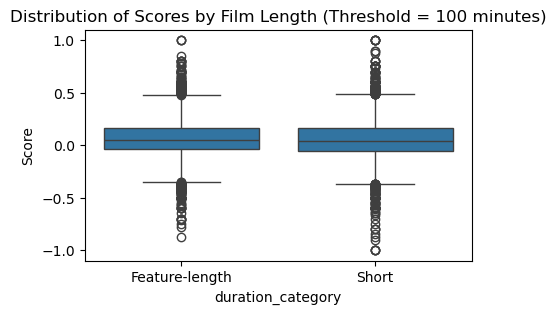

Descriptive Statistics by Duration Category:
                   mean  median  std  count
duration_category                          
Feature-length     0.06    0.05 0.18   5680
Short              0.06    0.05 0.18   5680

Normality Test (D'Agostino and Pearson):
Short Movies: Stat=249.4913, p-value=0.0000
Feature-length Movies: Stat=234.5275, p-value=0.0000
Short movies distribution does not follow a normal distribution.
Feature-length movies distribution does not follow a normal distribution.

Levene's Test for Equality of Variances: Statistic=4.0108, p-value=0.0452
Variances between short and feature-length movies are not equal.

Mann-Whitney U Test Results:
Statistic: 15833950.0000, p-value: 0.0889
The difference between short and feature-length movies is not statistically significant.


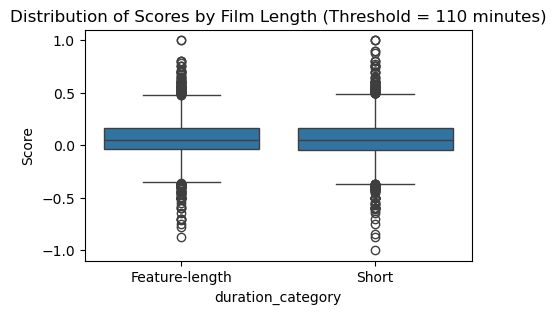

Descriptive Statistics by Duration Category:
                   mean  median  std  count
duration_category                          
Feature-length     0.07    0.06 0.18   2500
Short              0.05    0.05 0.18   2500

Normality Test (D'Agostino and Pearson):
Short Movies: Stat=115.7620, p-value=0.0000
Feature-length Movies: Stat=106.6960, p-value=0.0000
Short movies distribution does not follow a normal distribution.
Feature-length movies distribution does not follow a normal distribution.

Levene's Test for Equality of Variances: Statistic=0.2399, p-value=0.6243
Variances between short and feature-length movies are equal.

Mann-Whitney U Test Results:
Statistic: 2991320.5000, p-value: 0.0088
The difference between short and feature-length movies is statistically significant.


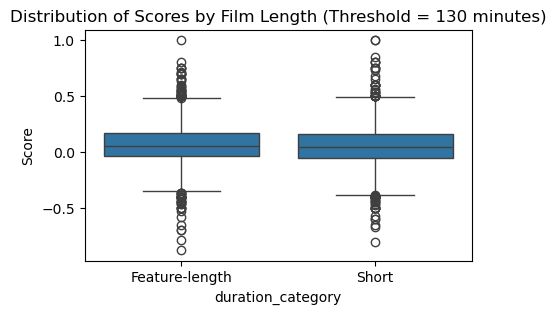

Descriptive Statistics by Duration Category:
                   mean  median  std  count
duration_category                          
Feature-length     0.07    0.06 0.18   1808
Short              0.06    0.05 0.18   1808

Normality Test (D'Agostino and Pearson):
Short Movies: Stat=97.7072, p-value=0.0000
Feature-length Movies: Stat=69.5218, p-value=0.0000
Short movies distribution does not follow a normal distribution.
Feature-length movies distribution does not follow a normal distribution.

Levene's Test for Equality of Variances: Statistic=0.6749, p-value=0.4114
Variances between short and feature-length movies are equal.

Mann-Whitney U Test Results:
Statistic: 1570975.0000, p-value: 0.0432
The difference between short and feature-length movies is statistically significant.


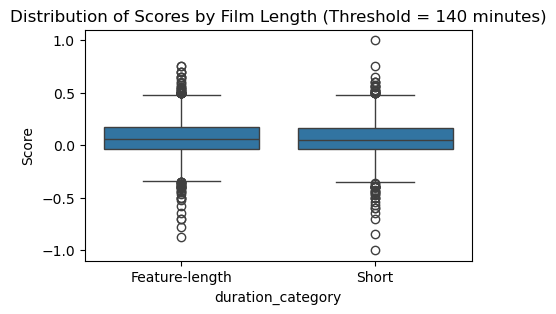

Descriptive Statistics by Duration Category:
                   mean  median  std  count
duration_category                          
Feature-length     0.02    0.01 0.15    104
Short              0.07    0.06 0.18    104

Normality Test (D'Agostino and Pearson):
Short Movies: Stat=7.1252, p-value=0.0284
Feature-length Movies: Stat=0.3064, p-value=0.8580
Short movies distribution does not follow a normal distribution.
Feature-length movies distribution follows a normal distribution.

Levene's Test for Equality of Variances: Statistic=1.2651, p-value=0.2620
Variances between short and feature-length movies are equal.

Mann-Whitney U Test Results:
Statistic: 6495.0000, p-value: 0.0123
The difference between short and feature-length movies is statistically significant.


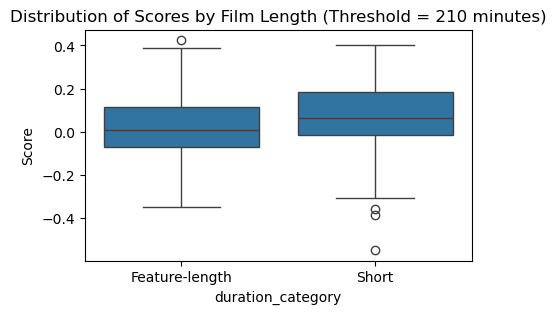

Descriptive Statistics by Duration Category:
                   mean  median  std  count
duration_category                          
Feature-length     0.01    0.00 0.14     81
Short              0.09    0.08 0.17     81

Normality Test (D'Agostino and Pearson):
Short Movies: Stat=8.7950, p-value=0.0123
Feature-length Movies: Stat=0.9144, p-value=0.6331
Short movies distribution does not follow a normal distribution.
Feature-length movies distribution follows a normal distribution.

Levene's Test for Equality of Variances: Statistic=2.4789, p-value=0.1174
Variances between short and feature-length movies are equal.

Mann-Whitney U Test Results:
Statistic: 4207.5000, p-value: 0.0019
The difference between short and feature-length movies is statistically significant.


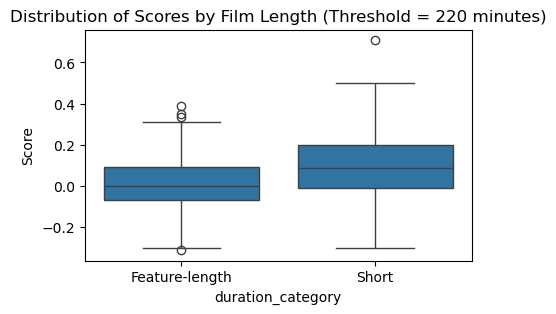

In [102]:
# Charger le dataset
DATA_FOLDER = '../../src/data/'
MOVIE_DATASET = DATA_FOLDER + 'movies_dataset_final.tsv'
movies = pd.read_csv(MOVIE_DATASET, sep='\t')


thresholds = range(10, 241, 10)  

for threshold in thresholds:
    results = analyze_movie_endings_by_threshold(movies, threshold=threshold, verbose=False)
    p_value = results['test']['p_value']
    if p_value < 0.05:
        print(f"Threshold: {threshold}, p-value: {p_value:.4f} - Significant")

new_thresholds = [100, 110, 130, 140, 210, 220]
for threshold in new_thresholds:
    results = analyze_movie_endings_by_threshold(movies, threshold=threshold)
 




In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Nettoyage des données une seule fois
movies['Movie runtime'] = pd.to_numeric(movies['Movie runtime'], errors='coerce')
movies_cleaned = movies.dropna(subset=['Movie runtime', 'Score'])
movies_cleaned = movies_cleaned[movies_cleaned['Movie runtime'] > 0]

# Ajouter la catégorie de durée avant
movies_cleaned['duration_category'] = movies_cleaned['Movie runtime'].apply(
    lambda x: 'Short' if x < 40 else 'Feature-length'
)

def plot_boxplot_by_threshold(movies_cleaned, threshold):
    # Séparer les scores en fonction de la catégorie
    short_scores = movies_cleaned[movies_cleaned['duration_category'] == 'Short']['Score']
    feature_scores = movies_cleaned[movies_cleaned['duration_category'] == 'Feature-length']['Score']
    
    # Visualisation des boxplots
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=movies_cleaned[movies_cleaned['Movie runtime'] < threshold], 
                x='duration_category', y='Score')
    plt.title(f'Distribution of Scores by Film Length (Threshold = {threshold} minutes)')
    plt.show()

# Créer le menu déroulant
threshold_dropdown = widgets.Dropdown(
    options=[(f'{i} minutes', i) for i in range(10, 241, 10)],
    value=40,
    description='Threshold:',
    disabled=False
)

# Créer l'interaction
widgets.interactive(plot_boxplot_by_threshold, movies_cleaned=widgets.fixed(movies_cleaned), threshold=threshold_dropdown)


### Test for three categories

These tests were conducted to assess whether movie scores differ significantly across three categories based on runtime: Short, Feature-length, and Long films. By performing normality tests (e.g., D'Agostino and Pearson's test), we ensure the data distribution aligns with assumptions for parametric tests. Levene's test for homogeneity of variances determines if the variability of scores is consistent across categories. Depending on these results, we use either ANOVA (for normal distributions and equal variances), Welch's ANOVA (for unequal variances), or the Kruskal-Wallis test (for non-normal distributions). This process allows for accurate statistical analysis of movie scores while accounting for differences in film length.

In [105]:
from scipy.stats import normaltest, levene, f_oneway, kruskal
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def analyze_movie_endings_three_categories(movies, thresholds=(40, 100), print_output=True):
    
    # Check necessary columns
    if 'Movie runtime' not in movies.columns or 'Score' not in movies.columns:
        raise ValueError("The DataFrame must contain the columns 'Movie runtime' and 'Score'")
    
    # Clean the data
    movies['Movie runtime'] = pd.to_numeric(movies['Movie runtime'], errors='coerce')
    movies_cleaned = movies.dropna(subset=['Movie runtime', 'Score'])
    movies_cleaned = movies_cleaned[movies_cleaned['Movie runtime'] > 0]
    
    # Categorize by thresholds
    low, high = thresholds
    movies_cleaned['duration_category'] = movies_cleaned['Movie runtime'].apply(
        lambda x: 'Short' if x < low else ('Feature-length' if x < high else 'Long')
    )
    
    # Downsampling to balance categories
    min_size = movies_cleaned['duration_category'].value_counts().min()
    downsampled_movies = (
        movies_cleaned.groupby('duration_category')
        .apply(lambda x: x.sample(n=min_size, random_state=42))
        .reset_index(drop=True)
    )
    
    if print_output:
        print(f"Downsampled categories to {min_size} movies each.")
    
    # Descriptive statistics
    group_stats = downsampled_movies.groupby('duration_category')['Score'].agg(['mean', 'median', 'std', 'count'])
    if print_output:
        print("\nDescriptive Statistics by Duration Category (Downsampled):")
        print(group_stats.to_string(index=True, float_format="{:.2f}".format))
    
    # Normality tests for each category
    normality_results = {}
    for category in ['Short', 'Feature-length', 'Long']:
        scores = downsampled_movies[downsampled_movies['duration_category'] == category]['Score']
        normality_results[category] = normaltest(scores)
        if print_output:
            print(f"\nNormality Test for {category} Movies: Stat={normality_results[category].statistic:.4f}, "
                  f"p-value={normality_results[category].pvalue:.4f}")
    
    # Levene's test for equality of variances
    short_scores = downsampled_movies[downsampled_movies['duration_category'] == 'Short']['Score']
    feature_scores = downsampled_movies[downsampled_movies['duration_category'] == 'Feature-length']['Score']
    long_scores = downsampled_movies[downsampled_movies['duration_category'] == 'Long']['Score']
    
    levene_stat, levene_p = levene(short_scores, feature_scores, long_scores)
    if print_output:
        print(f"\nLevene's Test for Equality of Variances: Statistic={levene_stat:.4f}, p-value={levene_p:.4f}")
    
    # Choosing the statistical test
    if all(normality_results[cat].pvalue > 0.05 for cat in ['Short', 'Feature-length', 'Long']):
        if levene_p > 0.05:
            # ANOVA if normality and equality of variances
            test_stat, test_p = f_oneway(short_scores, feature_scores, long_scores)
            test_name = "ANOVA (One-Way)"
        else:
            # Welch ANOVA if unequal variances
            test_stat, test_p = f_oneway(short_scores, feature_scores, long_scores)  # Welch-ANOVA requires statsmodels
            test_name = "Welch's ANOVA"
    else:
        # Kruskal-Wallis if non-parametric
        test_stat, test_p = kruskal(short_scores, feature_scores, long_scores)
        test_name = "Kruskal-Wallis Test"
    
    if print_output:
        print(f"\n{test_name} Results:")
        print(f"Statistic: {test_stat:.4f}, p-value: {test_p:.4f}")
    
    # Interpretation of the test
    if print_output:
        if test_p < 0.05:
            print("The differences between the three categories are statistically significant.")
        else:
            print("The differences between the three categories are not statistically significant.")
    
    # Visualization
    if print_output:
        plt.figure(figsize=(10, 5))
        sns.boxplot(data=downsampled_movies, x='duration_category', y='Score')
        plt.title(f'Distribution of Scores by Film Length Categories (Thresholds = {thresholds}, Downsampled)')
        plt.show()
    
    # Return results
    return {
        "group_stats": group_stats,
        "normality": {
            cat: {"statistic": normality_results[cat].statistic, "p_value": normality_results[cat].pvalue}
            for cat in ['Short', 'Feature-length', 'Long']
        },
        "levene": {"statistic": levene_stat, "p_value": levene_p},
        "test": {
            "name": test_name,
            "statistic": test_stat,
            "p_value": test_p
        }
    }


In [106]:

# Charger le dataset
DATA_FOLDER = '../../src/data/'
MOVIE_DATASET = DATA_FOLDER + 'movies_dataset_final.tsv'
movies_df = pd.read_csv(MOVIE_DATASET, sep='\t')


threshold_pairs = [
    (10, 60), (15, 70), (20, 80), (25, 90), (30, 100),
    (35, 110), (40, 120), (45, 130), (50, 140), (55, 150),
    (60, 160), (65, 170), (70, 180), (75, 190), (80, 200),
    (85, 210), (90, 220), (100, 130), (110, 150), (120, 160),
    (130, 170), (140, 180), (150, 190), (160, 200), (170, 210),
    (180, 220), (190, 210), (200, 220), (150, 200), (130, 180)
]

for thresholds in threshold_pairs:
    #print(f"\n--- Analyzing with thresholds: {thresholds} ---")
    result = analyze_movie_endings_three_categories(
        movies_df, thresholds=thresholds, print_output=False
    )
    
    # Vérifier si le p-value est significatif (moins de 0.05)
    p_value = result['test']['p_value']
    if p_value < 0.05:
        print(f"Threshold: {thresholds}, p-value: {p_value:.4f} - Significant")


/var/folders/wy/px61mqx17fxf319smbn_ydd80000gn/T/ipykernel_43371/4243723123.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_size, random_state=42))
/var/folders/wy/px61mqx17fxf319smbn_ydd80000gn/T/ipykernel_43371/4243723123.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_size, random_state=42))
/var/folders/wy/px61mqx17fxf319smbn_ydd8

Threshold: (20, 80), p-value: 0.0488 - Significant
Threshold: (35, 110), p-value: 0.0042 - Significant
Threshold: (45, 130), p-value: 0.0038 - Significant
Threshold: (50, 140), p-value: 0.0473 - Significant


/var/folders/wy/px61mqx17fxf319smbn_ydd80000gn/T/ipykernel_43371/4243723123.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_size, random_state=42))
/var/folders/wy/px61mqx17fxf319smbn_ydd80000gn/T/ipykernel_43371/4243723123.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_size, random_state=42))
/var/folders/wy/px61mqx17fxf319smbn_ydd8

Threshold: (90, 220), p-value: 0.0157 - Significant
Threshold: (100, 130), p-value: 0.0002 - Significant
Threshold: (110, 150), p-value: 0.0045 - Significant
Threshold: (170, 210), p-value: 0.0070 - Significant


/var/folders/wy/px61mqx17fxf319smbn_ydd80000gn/T/ipykernel_43371/4243723123.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_size, random_state=42))
/var/folders/wy/px61mqx17fxf319smbn_ydd80000gn/T/ipykernel_43371/4243723123.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_size, random_state=42))
/var/folders/wy/px61mqx17fxf319smbn_ydd8

Threshold: (190, 210), p-value: 0.0403 - Significant
Threshold: (150, 200), p-value: 0.0236 - Significant


/var/folders/wy/px61mqx17fxf319smbn_ydd80000gn/T/ipykernel_43371/4243723123.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_size, random_state=42))
/var/folders/wy/px61mqx17fxf319smbn_ydd80000gn/T/ipykernel_43371/4243723123.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_size, random_state=42))
